In [9]:
import os
import csv
import numpy as np
from geopy.distance import geodesic
from dwave.system import LeapHybridNLSampler
from dwave.optimization.model import Model
from dotenv import load_dotenv, find_dotenv
import networkx as nx
import matplotlib
try:
    import matplotlib.pyplot as plt
except ImportError:
    matplotlib.use("agg")
    import matplotlib.pyplot as plt

In [10]:
# Load Environmental Variables
load_dotenv(find_dotenv())
token = os.environ['DWAVE_API_KEY'] 

In [11]:
def read_data_from_csv(file_path):
    """
    Reads data from a CSV file with tab-delimited columns, adding a sequential index.

    Args:
        file_path (str): The path to the CSV file.

    Returns:
        list: A list of tuples containing the data, including the index.
            Each tuple has the format (index, name, latitude, longitude, selected).
    """
    data = []
    index = 0

    try:
        with open(file_path, 'r') as f:
            reader = csv.DictReader(f, delimiter='\t')
            for row in reader:
                try:
                    name = row['Location']
                    latitude = float(row['Latitude'])
                    longitude = float(row['Longitude'])
                    selected = int(row['Selected'])
                    data.append((index, name, latitude, longitude, selected))
                    index += 1
                except ValueError as e:
                    print(f"Error parsing row: {row}. {e}")
    except FileNotFoundError as e:
        print(f"File not found: {file_path}. {e}")

    return data

In [12]:
def calculate_distance_matrix(data):
    """
    Calculate a distance matrix between locations based on their coordinates.

    Args:
        data (list): A list of tuples containing location data.
            Each tuple should have the format (name, latitude, longitude, selected).

    Returns:
        np.ndarray: A NumPy array representing the distance matrix in kilometers.
    """
    # Extract coordinates and city names
    coordinates = [(lat, lon) for _, _, lat, lon, _ in data]
    city_names = [city for _, city, _, _, _ in data]

    # Initialize the distance matrix with zeros
    num_locations = len(data)
    distance_matrix = np.zeros((num_locations, num_locations))

    # Calculate distances using the Haversine formula
    for i in range(num_locations):
        for j in range(num_locations):
            if i != j:
                distance = geodesic(coordinates[i], coordinates[j]).kilometers
                distance_matrix[i][j] = distance

    return distance_matrix

In [13]:
def build_NL (distance_matrix):
    
    num_cities = distance_matrix.shape[0]
    # Construct the model
    tsp_model = Model()

    # Represent itineraries efficiently using permutations of an ordered list
    ordered_cities = tsp_model.list(num_cities)

    # Add the constants
    DISTANCE_MATRIX = tsp_model.constant(distance_matrix)

    itinerary = DISTANCE_MATRIX[ordered_cities[:-1], ordered_cities[1:]]
    return_to_origin = DISTANCE_MATRIX[ordered_cities[-1], ordered_cities[0]]

    # Sum the distances along the full route traveled.
    travel_distance = itinerary.sum() + return_to_origin.sum()

    # Minimize the total travel distance.
    tsp_model.minimize(travel_distance)
    tsp_model.lock()

    return tsp_model

In [14]:
def solve(tsp_model, time_limit=5):

    sampler = LeapHybridNLSampler(token=token)
    results = sampler.sample(
                            tsp_model,
                            time_limit=time_limit,
                            label='TSP_NL')
    route, = tsp_model.iter_decisions()

    feasible_samples = []
    energies = []
    for i in range(tsp_model.states.size()):
        if not (tsp_model.iter_constraints()):
            raise ValueError("No feasible solution found")
        else:
            feasible_samples.append((route.state(i)))
            energies.append(tsp_model.objective.state(i))
    solution = feasible_samples[0]
    energy = energies[0]

  
    return solution, energy

In [15]:
def parse_solution(solution):

    integer_list = list(map(int, solution))
    index_to_city = {i: data[i][1] for i in integer_list}
    optimized_tour = []
    for i in range(len(index_to_city.values())):
        current_city = list(index_to_city.values())[i]
        if i == len(index_to_city.values()) - 1:
            next_city = list(index_to_city.values())[0]
        else:
            next_city = list(index_to_city.values())[i + 1]
        optimized_tour.append((current_city, next_city))
    
    return optimized_tour

In [16]:
def print_solution(solution):

    """
    Print the optimized tour based on the provided solution.

    Args:
        solution (list): The solution list of tuples containing the the couple of cities selected
    """

    # Extract city names and coordinates from the data structure
    city_coordinates = {city: (lat, lon) for _, city, lat, lon, _ in data}

    # Set the figure size 
    plt.figure(figsize=(20, 10))

    # Plot the tour path on the map 
    for from_city, to_city in optimized_tour:
        from_coords = city_coordinates[from_city]
        to_coords = city_coordinates[to_city]

        #  arrows 
        plt.arrow(from_coords[1], from_coords[0],  # Swap lat and long for Matplotlib
                to_coords[1] - from_coords[1], to_coords[0] - from_coords[0],
                head_width=0.5, head_length=0.5, fc='red', ec='blue')

        # Display the city name as text
        plt.text(from_coords[1], from_coords[0], from_city, fontsize=10, ha='right', va='bottom')
        plt.text(to_coords[1], to_coords[0], to_city, fontsize=10, ha='right', va='bottom')

    # Remove x-axis and y-axis labels and ticks
    plt.xticks([])
    plt.yticks([])

    # Print the total cost 
    print(f'Total cost of the tour is: {int(energy)} \n')
    
    print("Optimal Tour: ")
    for from_city, to_city in optimized_tour:
        print(f"{from_city} -> {to_city}")

    # Save the plot to a file
    plt.savefig('optimized_tour.png')

    plt.show()
    plt.close()

In [17]:
# Define the path to the CSV file containing location data
file_path = 'locations.csv'

# Read data from the CSV file using a custom function (read_data_from_csv)
data = read_data_from_csv(file_path)

# Calculate the distance matrix for the selected subset of cities
distance_matrix = calculate_distance_matrix(data)

In [18]:
# Initialize the model
tsp = build_NL(distance_matrix)

# Instantiate the sampler
solution, energy = solve(tsp)

Total cost of the tour is: 17101 

Optimal Tour: 
Phoenix_AZ -> Santa-Fe_NM
Santa-Fe_NM -> Oklahoma-City_OK
Oklahoma-City_OK -> Austin_TX
Austin_TX -> Baton-Rouge_LA
Baton-Rouge_LA -> Jackson_MS
Jackson_MS -> Little-Rock_AR
Little-Rock_AR -> Jefferson-City_MO
Jefferson-City_MO -> Topeka_KS
Topeka_KS -> Lincoln_NE
Lincoln_NE -> Des-Moines_IA
Des-Moines_IA -> Springfield_IL
Springfield_IL -> Indianapolis_IN
Indianapolis_IN -> Frankfort_KY
Frankfort_KY -> Nashville_TN
Nashville_TN -> Atlanta_GA
Atlanta_GA -> Montgomery_AL
Montgomery_AL -> Tallahassee_FL
Tallahassee_FL -> Columbia_SC
Columbia_SC -> Raleigh_NC
Raleigh_NC -> Richmond_VA
Richmond_VA -> Annapolis_MD
Annapolis_MD -> Dover_DE
Dover_DE -> Trenton_NJ
Trenton_NJ -> Hartford_CT
Hartford_CT -> Providence_RI
Providence_RI -> Boston_MA
Boston_MA -> Concord_NH
Concord_NH -> Augusta_ME
Augusta_ME -> Montpelier_VT
Montpelier_VT -> Albany_NY
Albany_NY -> Harrisburg_PA
Harrisburg_PA -> Charleston_WV
Charleston_WV -> Columbus_OH
Columbus_OH 

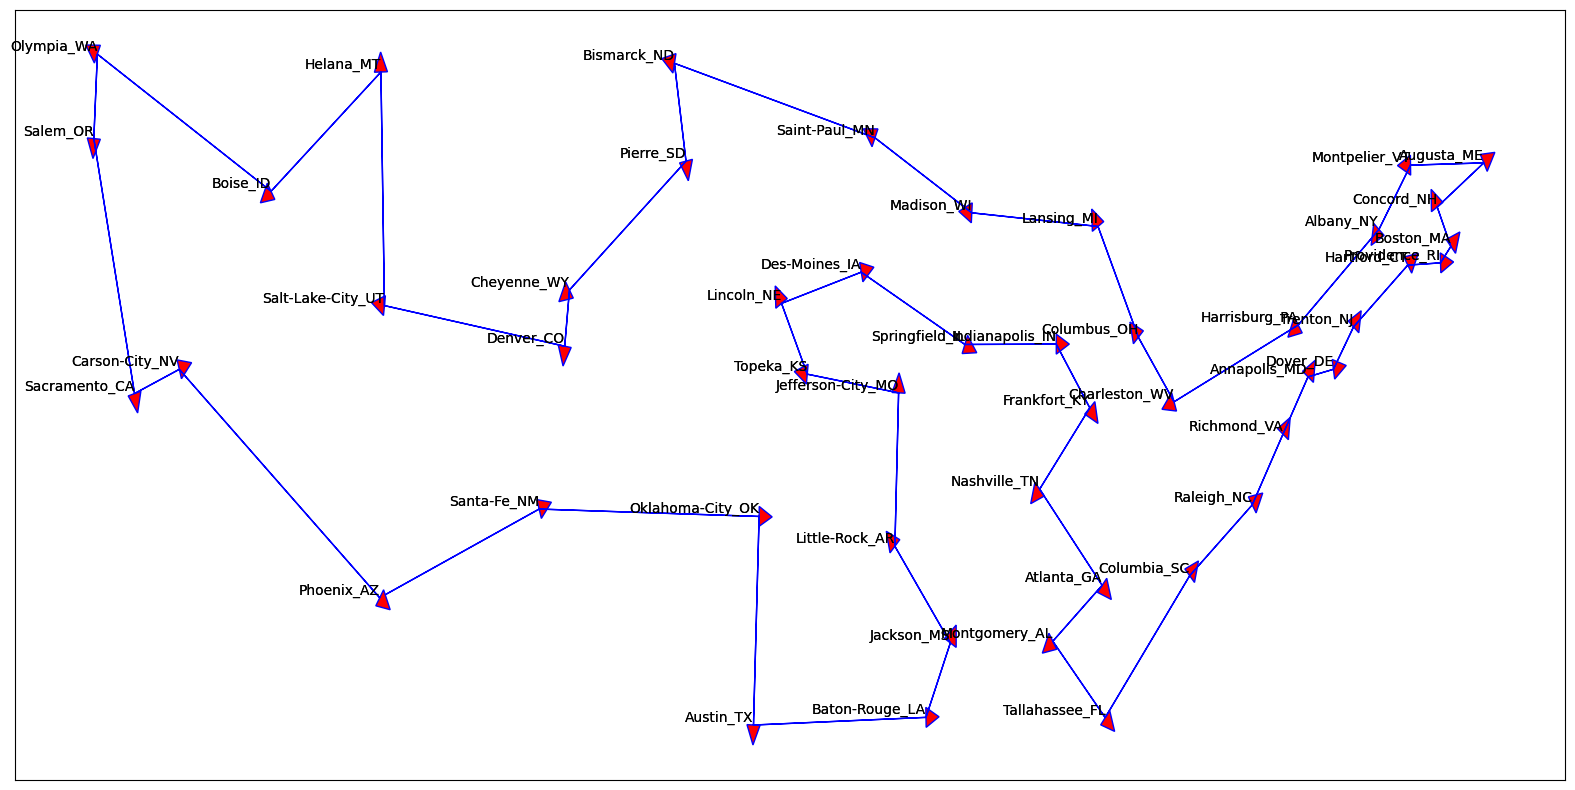

In [19]:
# Parse solution
optimized_tour = parse_solution(solution)

# Print solution in a diagram
print_solution(optimized_tour)